In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib.pyplot as plt
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [2]:
# 读取Excel文件
excel_path = f"随机噪声-专用数据1.xlsx"
# df_sheet = pd.read_excel(excel_path, sheet_name='剔除异常值') 
# df_sheet = pd.read_excel(excel_path, sheet_name='SI全') 
# df_sheet = pd.read_excel(excel_path, sheet_name='温度全') 
df_sheet = pd.read_excel(excel_path, sheet_name='主参数全') 
print(df_sheet.columns)
print(df_sheet.info())


Index(['时间戳', '时间差', '富氧流量', '冷风流量', '热风压力', '热风温度', '鼓风湿度', '设定喷煤量', '上小时喷煤量',
       '冷风压力'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7453 entries, 0 to 7452
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间戳     7453 non-null   int64  
 1   时间差     7453 non-null   int64  
 2   富氧流量    7453 non-null   int64  
 3   冷风流量    7453 non-null   float64
 4   热风压力    7453 non-null   float64
 5   热风温度    7453 non-null   int64  
 6   鼓风湿度    7453 non-null   float64
 7   设定喷煤量   7453 non-null   float64
 8   上小时喷煤量  7436 non-null   float64
 9   冷风压力    7453 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 582.4 KB
None


In [3]:
# 获取DataFrame中的所有列名
# input_term = 'SI'
# input_term = '铁口1温度'
# input_term = '富氧流量'
# input_term = '冷风流量'
# input_term = '热风压力'
# input_term = '热风温度'
# input_term = '鼓风湿度'
# input_term = '设定喷煤量'
input_term = '冷风压力'

d_time = '时间差'
time_term = '时间戳'


In [4]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    time_term:  df_sheet[time_term].values,
    input_term:   df_sheet[input_term].values,
    d_time:   df_sheet[d_time].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(1, 10))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [5]:
import numpy as np

def check_stationarity(X):
    # 计算时间序列的长度
    n = len(X)
    
    # 计算时间序列的均值
    mean_X = np.mean(X)
    
    # 计算时间序列的方差
    var_X = np.var(X)
    
    # 计算时间序列的自相关系数
    autocov_X = np.correlate(X - mean_X, X - mean_X, mode='full') / n
    
    # 根据定义检查平稳性
    condition_1 = np.abs(mean_X) < 1e-6 # 使用一个极小的值来判断均值是否为零
    condition_2 = var_X < np.inf
    condition_3 = np.allclose(autocov_X[:n], autocov_X[n-1:]) # 检查自相关系数是否在时间偏移后保持不变
    
    return condition_1 and condition_2 and condition_3




In [6]:
# 示例时间序列
X = normalized_data_dict[input_term]
# 检查时间序列的平稳性
if check_stationarity(X):
    print("时间序列是平稳的。")
else:
    print("时间序列不是平稳的。")


时间序列不是平稳的。


In [43]:
# 生成数据
print(len(normalized_data_dict[input_term]))
index = np.arange(5400, 5800, 1)
t           = original_data_dict[time_term][index]
y_observed  = original_data_dict[input_term][index]  # 观察到的数据
delta       = original_data_dict[d_time][index][:-1]


7453


In [44]:
# 噪声分量参数估计
import numpy as np
from scipy.optimize import minimize

# 假设观测值为 x，时间间隔为 delta
# 你需要提供你的观测值 x 和时间间隔 delta
# 示例数据：
X = (y_observed)


print(X)
print(X.shape)
print(delta.shape)

# 定义最小二乘法的目标函数
def least_squares_objective(theta, x, delta):
    n = len(x)
    residuals = x[1:] - theta ** delta * x[:-1]
    return np.sum(np.fabs(residuals)**2)




# 通过最小二乘法估计参数 theta
initial_guess_theta = 0.5  # 初始猜测值
result_theta = minimize(least_squares_objective, initial_guess_theta, args=(X, delta))
estimated_theta = result_theta.x[0]

# # 估计σ
# residuals = x[1:] - estimated_theta ** delta * x[:-1]
# sigma_square_delta = np.mean(residuals**2) / (1 - estimated_theta**2 * np.mean(delta**2) / (1 - estimated_theta**2))
# estimated_sigma = np.sqrt(sigma_square_delta)
# 估计σ

sum_0 = 0
for i in range(len(delta)):
    sum_0 = sum_0 + (X[i+1] - estimated_theta ** delta[i] * X[i])**2 / ((1-estimated_theta**(2*delta[i])) /(1-estimated_theta**(2))) 

estimated_sigma = np.sqrt(sum_0/(len(delta)+1))

print(f"Estimated theta: {estimated_theta}")
print(f"Estimated sigma: {estimated_sigma}")




[0.428 0.422 0.427 0.424 0.42  0.421 0.422 0.421 0.424 0.421 0.42  0.42
 0.422 0.418 0.418 0.421 0.413 0.418 0.422 0.417 0.417 0.416 0.416 0.413
 0.419 0.416 0.416 0.419 0.422 0.421 0.418 0.422 0.419 0.413 0.405 0.416
 0.417 0.377 0.389 0.403 0.413 0.42  0.419 0.413 0.421 0.421 0.425 0.424
 0.418 0.422 0.422 0.421 0.421 0.421 0.417 0.417 0.42  0.419 0.422 0.429
 0.422 0.425 0.423 0.423 0.419 0.424 0.427 0.426 0.424 0.418 0.421 0.415
 0.421 0.408 0.413 0.414 0.415 0.413 0.416 0.413 0.409 0.415 0.412 0.413
 0.416 0.413 0.416 0.417 0.416 0.417 0.419 0.416 0.42  0.415 0.415 0.413
 0.419 0.418 0.419 0.416 0.417 0.418 0.417 0.418 0.417 0.421 0.42  0.417
 0.418 0.422 0.414 0.418 0.423 0.415 0.416 0.418 0.416 0.412 0.42  0.416
 0.419 0.42  0.425 0.417 0.421 0.42  0.417 0.417 0.418 0.415 0.421 0.415
 0.419 0.413 0.417 0.414 0.415 0.418 0.416 0.42  0.419 0.42  0.421 0.423
 0.42  0.419 0.422 0.422 0.422 0.423 0.418 0.421 0.419 0.419 0.412 0.414
 0.412 0.412 0.416 0.415 0.417 0.419 0.419 0.418 0.4

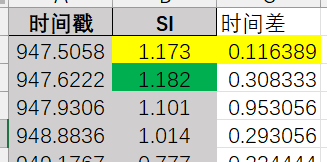

(400,)
(399,)


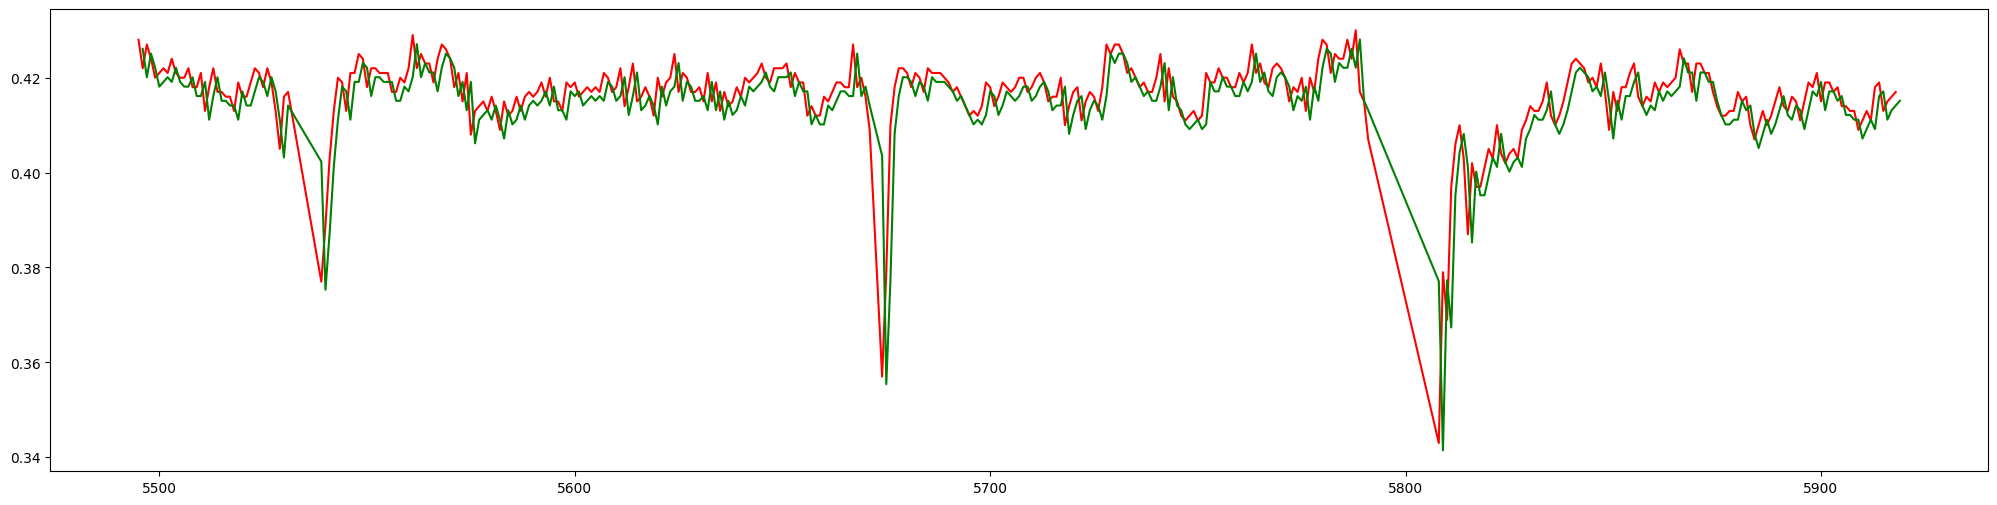

In [45]:
# 一步预测
def one_step_predictor(theta, x, delta):
    return theta ** delta * x[:-1]

# 使用估计的参数进行一步预测
predicted_values = one_step_predictor(estimated_theta, X, delta)

plt.figure(figsize=(25, 6))
plt.plot(t[:-1], X[:-1], 'r')
plt.plot(t[1:],predicted_values, 'g')
print(X.shape)
print(predicted_values.shape)


In [10]:
# 预测
# 时间戳范围
timestamps_to_predict = np.arange(np.floor(min(df_sheet[time_term][index]))+1,
                                np.floor(max(df_sheet[time_term][index]))+1,
                                1)
df_sheet2 = df_sheet
df_sheet3 = pd.DataFrame()
isprint = 0
for id,y_predict_time in enumerate(timestamps_to_predict):
    print(y_predict_time,end='\r')
    if isprint:
        print(id,y_predict_time,'000000000000000000000000000000000000000000000000000000000000000000000')
    # y_predict_time = 950

    # 找到比 item 小且最接近的1个数据
    closest_10 = df_sheet[df_sheet[time_term] < y_predict_time].nlargest(1, time_term)
    closest_10_sorted = closest_10.sort_values(by=time_term)
    if isprint:
        print('df:')
        print(closest_10_sorted)
        print('  ')

    y_last_time = closest_10_sorted.iloc[-1][time_term]
    y_last_time_transform = scalers[time_term].transform(y_last_time.reshape(-1,1)).flatten()
    if isprint:
        print('y_last_time:')
        print(y_last_time)
        print(y_last_time_transform)
        print('  ')

    delta_to_predict = y_predict_time - y_last_time
    delta_to_predict_transform = scalers[d_time].transform(delta_to_predict.reshape(-1,1)).flatten()
    if isprint:
        print('delta_to_predict:')
        print(delta_to_predict)
        print(delta_to_predict_transform)
        print('  ')


    y_last_observed = closest_10_sorted.iloc[-1][input_term]
    y_last_observed_transform = scalers[input_term].transform(y_last_observed.reshape(-1,1)).flatten()

    if isprint:
        print('y_last_observed_to_predict:')
        print(y_last_observed)
        print(y_last_observed_transform)
        print('  ')


    # 使用估计的参数进行一步预测
    predicted_values = (estimated_theta ** delta_to_predict_transform * y_last_observed_transform)
    predicted_values_transform = scalers[input_term].inverse_transform((predicted_values.reshape(-1,1))).flatten()
    if isprint:
        print('predicted_values:')
        print(predicted_values)
        print(predicted_values_transform)
        print('  ')




    new_row = {time_term: y_predict_time, input_term: predicted_values_transform.item(), d_time: delta_to_predict}
    df_sheet2 = pd.concat([df_sheet2, pd.DataFrame([new_row])], ignore_index=True)
    df_sheet2 = df_sheet2.sort_values(by=time_term)
    df_sheet3 = pd.concat([df_sheet3, pd.DataFrame([new_row])], ignore_index=True)
    df_sheet3 = df_sheet3.sort_values(by=time_term)



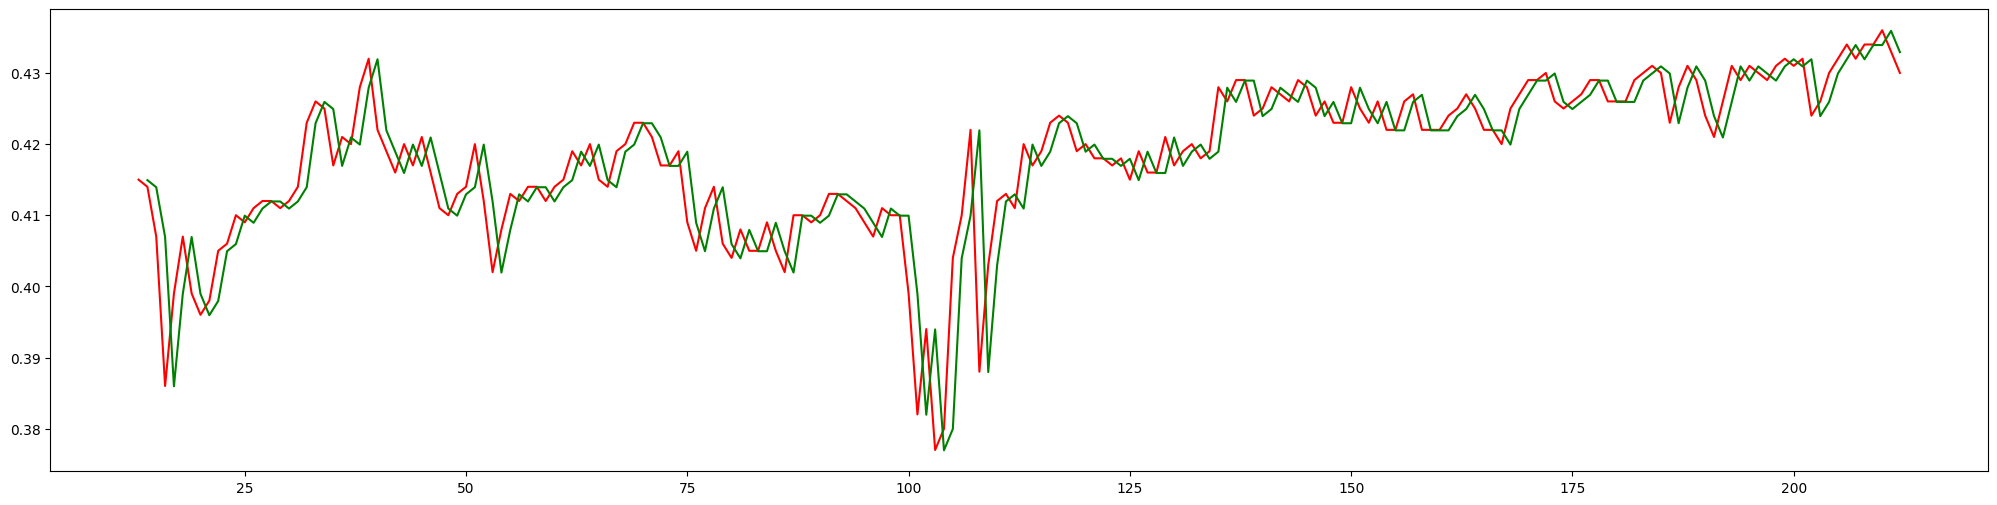

In [11]:
# 绘制结果
plt.figure(figsize=(25, 6))
plt.plot(df_sheet['时间戳'][index],df_sheet[input_term][index],'r-', label='填充后数据') # 使用中文标签
plt.plot(df_sheet3['时间戳'][:],df_sheet3[input_term][:],'g-', label = '填充后数据') # 使用中文标签


In [12]:
df_sheet3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间戳     199 non-null    float64
 1   冷风压力    199 non-null    float64
 2   时间差     199 non-null    float64
dtypes: float64(3)
memory usage: 4.8 KB


In [13]:
df_sheet3.tail()


,时间戳,冷风压力,时间差
194,208.0,0.431925,1.0
195,209.0,0.433923,1.0
196,210.0,0.433923,1.0
197,211.0,0.435922,1.0
198,212.0,0.432924,1.0


In [14]:
# 保存整理后的 df_sheet 到 Excel 文件
df_sheet3.to_excel(input_term+'_output.xlsx', index=False)
print('DataFrame 已保存到'+input_term+' output.xlsx 文件')


DataFrame 已保存到冷风压力 output.xlsx 文件
